# All imports

In [384]:
import os
import cv2
from os import listdir
from os.path import isfile, join

import random
import numpy as np

from imgaug import augmenters as iaa
import PIL.Image as Image
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

from IPython.core.display import display, HTML
from IPython.display import display
display(HTML("<style>.container { width:100% !important; }</style>"))

covid_images_path = os.path.join("images", "COVID-19") 
normal_images_path = os.path.join("images", "Normal")
bacteria_images_path = os.path.join("images", "Bacteria")
virus_images_path = os.path.join("images", "Virus")

covid_images = [os.path.join(covid_images_path, f) for f in listdir(covid_images_path) if isfile(join(covid_images_path, f))]
normal_images = [os.path.join(normal_images_path, f) for f in listdir(normal_images_path) if isfile(join(normal_images_path, f))]
bacteria_images = [os.path.join(bacteria_images_path, f) for f in listdir(bacteria_images_path) if isfile(join(bacteria_images_path, f))]
virus_images = [os.path.join(virus_images_path, f) for f in listdir(virus_images_path) if isfile(join(virus_images_path, f))]

print(f"Total covid_images: {len(covid_images)}")
print(f"Total normal_images: {len(normal_images)}")
print(f"Total bacteria_images: {len(bacteria_images)}")
print(f"Total virus_images: {len(virus_images)}")

Total covid_images: 179
Total normal_images: 179
Total bacteria_images: 179
Total virus_images: 179


In [2]:
import tensorflow as tf

from keras import backend as K
from keras.backend.tensorflow_backend import set_session
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LambdaCallback
from keras.layers import Input, Dropout, GlobalAveragePooling2D, AveragePooling2D, BatchNormalization, Conv2D
from keras.layers import Flatten, Dense, MaxPooling2D, ReLU, Concatenate
from keras.models import Model, load_model
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.regularizers import l2
from keras.applications import ResNet50V2, ResNet50, MobileNetV2, VGG16, DenseNet121
from keras.applications.vgg16 import preprocess_input
from keras.layers import LeakyReLU
from keras.activations import linear, softmax, sigmoid

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Preparing our dataset

In [471]:
image_size = (100, 100)

def resize_image(img_array):
    img = Image.fromarray(img_array)
    img = img.resize(image_size)
    return np.array(img)

def show_images(images, title=""):
    fig, ax = plt.subplots(1, len(images), figsize=(15, 15), dpi=100)   
    for i, img in enumerate(images):
#         img = (img * 255).astype(np.uint8)
        ax[i].imshow(img)
        ax[i].set_title(title)
    [x.axis('off') for x in ax]
    plt.show()
    
def convert_images(image_paths):
    images = [np.array(Image.open(img).convert('RGB')) for img in image_paths if os.path.exists(img)]
    images = [resize_image(img) for img in images]    
    return np.array(images)

In [493]:
# Extracting meta data
df_meta = pd.read_csv("metadata.csv")

# Extract only selectd columns and filter b COVID-19 cases
df_meta = df_meta[["finding", "date", "location", "filename", "modality"]]
result = [idx for idx, row in df_meta.iterrows() 
                      if "COVID-19" in row["finding"] 
                      and "X-ray" in row["modality"] 
                      and os.path.exists(join(covid_images_path, row["filename"]))]
df_meta = df_meta.iloc[result]

# adding image path to filename column  
for idx, row in df_meta.iterrows():
    row["filename"] = join(covid_images_path, row["filename"])
    
print(df_meta.info())
df_meta.sample(n=5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 0 to 298
Data columns (total 5 columns):
finding     179 non-null object
date        166 non-null object
location    125 non-null object
filename    179 non-null object
modality    179 non-null object
dtypes: object(5)
memory usage: 8.4+ KB
None


,finding,date,location,filename,modality
298,COVID-19,NaN,"Nottingham, United Kingdom",images\COVID-19\covid-19-pneumonia-44-day-8.jpeg,X-ray
22,COVID-19,19-Jan-20,"Snohomish County, Washington, USA",images\COVID-19\nejmoa2001191_f1-PA.jpeg,X-ray
275,COVID-19,2020,NaN,images\COVID-19\radiol.2020201160.fig3b.jpeg,X-ray
153,COVID-19,2020,NaN,images\COVID-19\figure1-5e71be566aa8714a04de33...,X-ray
283,COVID-19,NaN,"Zahedan, Iran",images\COVID-19\covid-19-pneumonia-8.jpg,X-ray


In [494]:
covid_image_arrs = convert_images(df_meta['filename'])
normal_image_arrs = convert_images(normal_images)
bacteria_image_arrs = convert_images(bacteria_images)
virus_image_arrs = convert_images(virus_images)

labels = ["Normal", "COVID-19", "Bacteria"]

print(f"covid_image_arrs: {covid_image_arrs.shape}")
print(f"normal_image_arrs: {normal_image_arrs.shape}")
print(f"bacteria_image_arrs: {bacteria_image_arrs.shape}")
print(f"virus_image_arrs: {virus_image_arrs.shape}")

covid_image_arrs: (179, 100, 100, 3)
normal_image_arrs: (179, 100, 100, 3)
bacteria_image_arrs: (179, 100, 100, 3)
virus_image_arrs: (179, 100, 100, 3)


# Customise our model and extract features
We will extract the 2nd last dense layer right before the classification layer to use it as feature provider. 

1. Load the trained model and weights
2. Modify the model to provide features

In [6]:
# Convert learning_rate field to lr.
# import h5py
# f = h5py.File('weights/vgg16_covid19_weights.hd5', 'r+')
# data_p = f.attrs['training_config']
# data_p = data_p.decode().replace("learning_rate","lr").encode()
# f.attrs['training_config'] = data_p
# f.close()

In [7]:
from keras.models import load_model
model = load_model('weights/vgg16_covid19_weights.hd5')

W0413 14:00:40.229927  9940 module_wrapper.py:139] From D:\Programs\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0413 14:00:40.240653  9940 module_wrapper.py:139] From D:\Programs\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0413 14:00:40.268661  9940 module_wrapper.py:139] From D:\Programs\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0413 14:00:40.413795  9940 module_wrapper.py:139] From D:\Programs\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4271: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0413 14:00:40.429792  9940 module_wrapper.py:139] From D:\Programs\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.

In [8]:
# removing final 2 layers exposing dense_26 
model.layers.pop()
model.layers.pop()

# Reconstruct the model to output features
model = Model(inputs=model.input, outputs=model.get_layer('dense_26').output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0   

## Extracting features using our customised model

In [495]:
features = model.predict(covid_image_arrs)
print(features.shape)

(179, 64)


# Dimesion reduction using PCA

In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

In [476]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
print(pca_result.shape)

# Convert to pandas dataframe
df_pca2 = pd.DataFrame(pca_result)
df_pca2.sample(n=5)

(179, 2)


,0,1
167,86.822296,-53.870869
57,-131.358490,104.467194
18,91.341125,-85.398079
99,-77.193733,55.158188
60,-51.971252,24.692451


## Show PCA in 2 dimensions

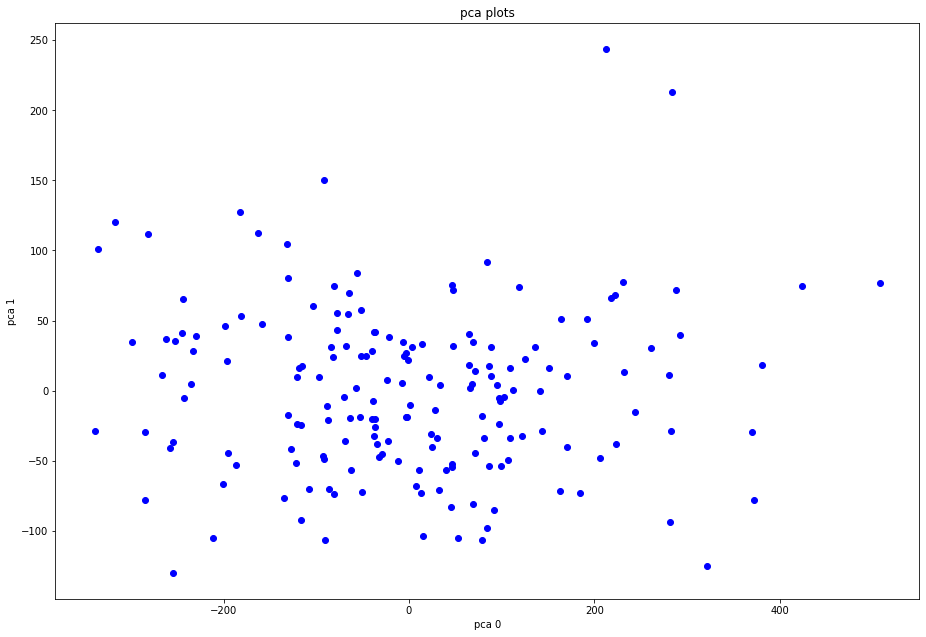

In [477]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_axes([0,0,2,2])
ax.scatter(df_pca2[0], df_pca2[1], color='b')
ax.set_xlabel('pca 0')
ax.set_ylabel('pca 1')
ax.set_title('pca plots')
plt.show()

## Show PCA in 3 dimensiions

In [394]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(features)
print(pca_result.shape)

# Convert to pandas dataframe
df_pca3 = pd.DataFrame(pca_result)
df_pca3.sample(n=5)

(179, 3)


,0,1,2
61,-266.662811,11.297876,29.045277
9,-2.860614,-18.952595,-1.891497
4,66.281578,1.859644,-32.482944
131,-62.975037,-56.776989,-54.719154
81,-115.505959,17.813557,-27.132584


<IPython.core.display.Javascript object>


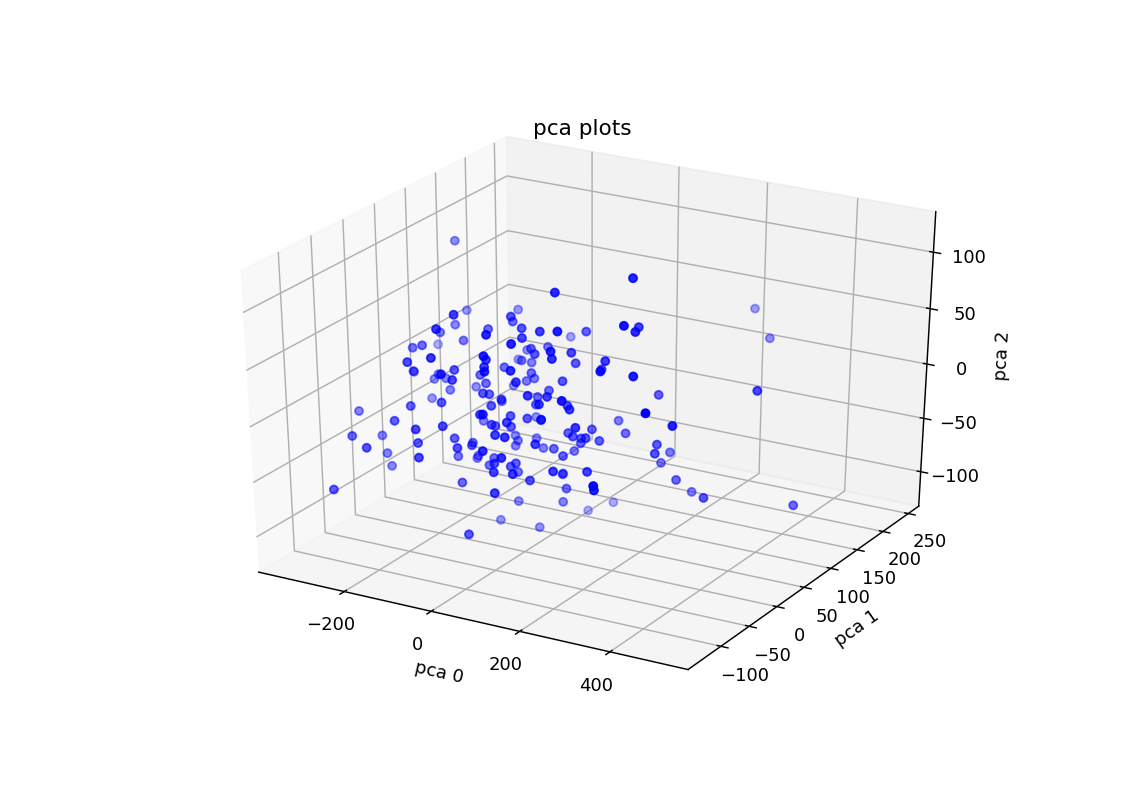

In [417]:
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_pca3[0], df_pca3[1], df_pca3[2], color='b')
ax.set_xlabel('pca 0')
ax.set_ylabel('pca 1')
ax.set_zlabel('pca 2')
ax.set_title('pca plots')
plt.show()

# Dimesion reduction using t-SNE

## Show t-SNE in 2 dimensions

In [478]:
tsne = TSNE(n_components=2, verbose=0, perplexity=90, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(features)
print(tsne_results.shape)

# Convert to pandas dataframe
df_tsne2 = pd.DataFrame(tsne_results)
df_tsne2.sample(n=3)

(179, 2)


,0,1
86,0.322211,2.117899
5,0.118268,-3.176126
133,-0.790411,-0.464935


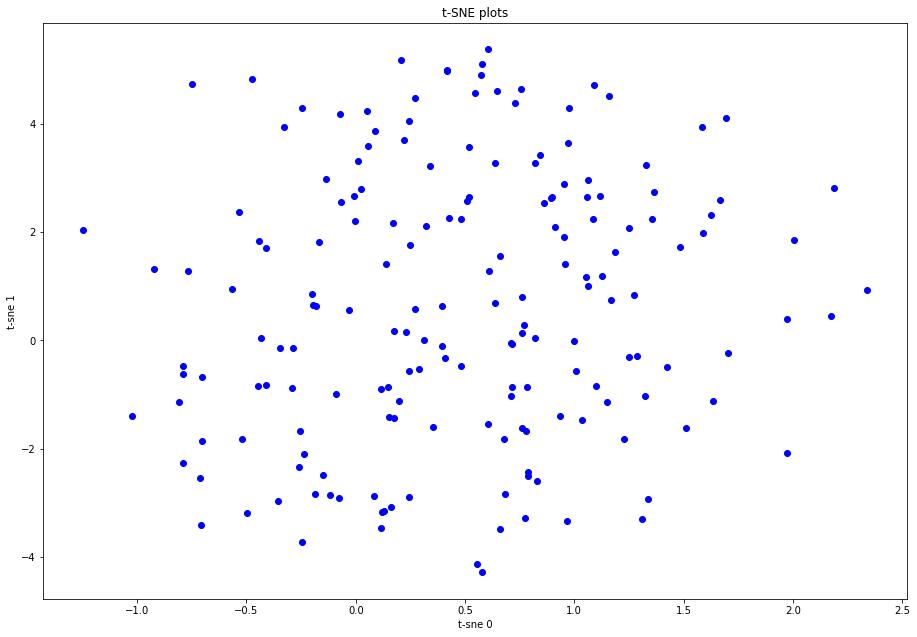

In [479]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_axes([0,0,2,2])
ax.scatter(df_tsne2[0], df_tsne2[1], color='b')
ax.set_xlabel('t-sne 0')
ax.set_ylabel('t-sne 1')
ax.set_title('t-SNE plots')
plt.show()

## Show t-SNE in 3 dimensions

In [419]:
tsne = TSNE(n_components=3, verbose=0, perplexity=90, n_iter=2000, random_state=100)
tsne_results = tsne.fit_transform(features)
print(tsne_results.shape)

# Convert to pandas dataframe
df_tsne3 = pd.DataFrame(tsne_results)
df_tsne3.sample(n=3)

(179, 3)


,0,1,2
121,-104.508194,-175.812546,142.440643
136,2.028417,159.278061,-108.771416
150,-300.794128,-3.557697,21.655407


<IPython.core.display.Javascript object>


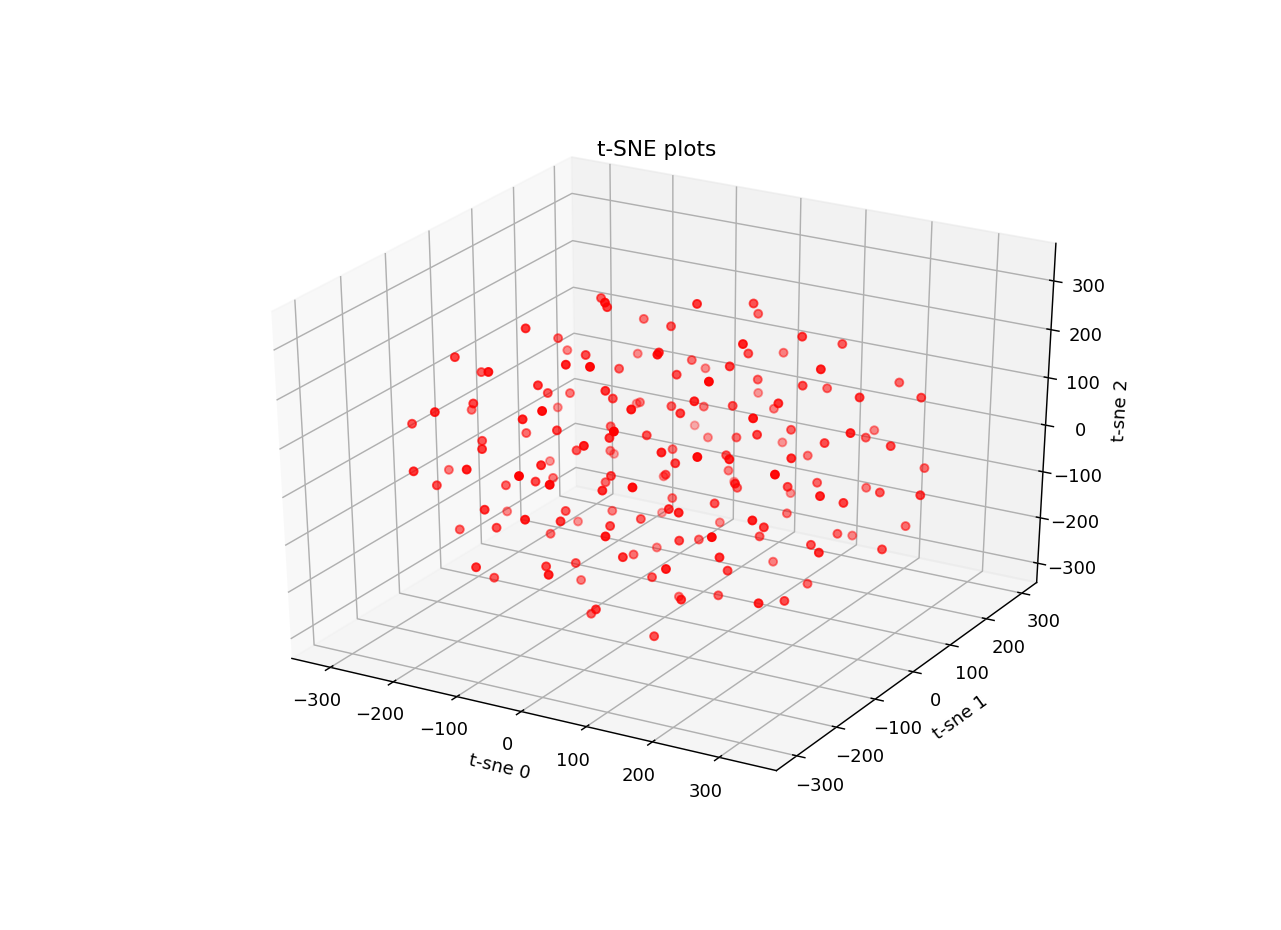

In [420]:
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_tsne3[0], df_tsne3[1], df_tsne3[2], color='r')
ax.set_xlabel('t-sne 0')
ax.set_ylabel('t-sne 1')
ax.set_zlabel('t-sne 2')
ax.set_title('t-SNE plots')
plt.show()

# Using DBSCAN for clustering
Reference for sklearn DBSCAN: https://scikit-learn.org/stable/modules/clustering.html#dbscan

 Indicate higher density necessary to form a cluster. (Stricten requirement to form clusters)
 - Higher - min_samples 
 - lower - eps 


In [480]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from collections import Counter

def compute_dbscan_score(db_labels):
    """
    Attempt to find the best DBSCAN parameters by calculating how clusters are balanced
    """
    # forming cluster dictionary
    cluster_dic = dict(Counter(db_labels))
    
    # Compute the difference in number of nodes of each clusters
    # The lower the value, the better cluster is formed
    # print(cluster_dic.values())
    max_value = np.amax(list(cluster_dic.values()), axis=0)
    score = 0
    for key in cluster_dic.keys():
        if key != -1: # not outliers class 
            score += max_value - cluster_dic[key]
        else: # we want as less outlier as possible
            score += cluster_dic[key]
    return score

def dbscan_grid_search(df, min_cluster=3, max_cluster=8, eps_range=np.arange(0.1, 2.0, 0.1), min_samples=np.arange(5, 20, 1), verbose=False):
    """
        Grid search on dbscan to find the best parameters for clustering. The lower the score the better the clustering is form.
        
        Parameters:
        * df - dataframe to compute for clusters 
        * min_cluster = 3
        * max_cluster = 8
        * eps_range = np.arange(0.1, 2.0, 0.1)
        * min_samples = np.arange(5, 20, 1)
        
        Return:
        List of parameters and scores on clustering
    """
    results = []

    dbscan_scaler = StandardScaler()
    df_normalise = dbscan_scaler.fit_transform(df.values)

    n_iteration = 0

    for eps in eps_range:
        for min_sam in min_samples: 
            db = DBSCAN(eps=eps, min_samples=min_sam).fit(df_normalise)

            core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
            core_samples_mask[db.core_sample_indices_] = True
            db_labels = db.labels_

            # Number of clusters in labels, ignoring noise if present.
            n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
            n_noise_ = list(db_labels).count(-1)

            n_iteration += 1

            if min_cluster <= n_clusters_ <= max_cluster:
                params = {}
                params['eps'] = round(eps, 2)
                params['min_samples'] = min_sam
                params['n_clusters'] = n_clusters_
                params['score'] = compute_dbscan_score(db_labels)
                results.append(params)
    if verbose:
        print(f"Total hyperparameters checked: {n_iteration}")
        print(f"Total results: {len(results)}")
    return sorted(results, key=lambda x: x['score'], reverse=False)

## Result for PCA

In [481]:
results = dbscan_grid_search(df_pca2)
results

[{'eps': 0.3, 'min_samples': 8, 'n_clusters': 4, 'score': 319},
 {'eps': 0.4, 'min_samples': 17, 'n_clusters': 3, 'score': 356},
 {'eps': 0.3, 'min_samples': 9, 'n_clusters': 4, 'score': 361},
 {'eps': 0.4, 'min_samples': 18, 'n_clusters': 3, 'score': 366},
 {'eps': 0.3, 'min_samples': 11, 'n_clusters': 3, 'score': 406},
 {'eps': 0.3, 'min_samples': 10, 'n_clusters': 4, 'score': 427},
 {'eps': 0.4, 'min_samples': 5, 'n_clusters': 5, 'score': 500},
 {'eps': 0.3, 'min_samples': 12, 'n_clusters': 4, 'score': 583},
 {'eps': 0.2, 'min_samples': 5, 'n_clusters': 4, 'score': 619},
 {'eps': 0.2, 'min_samples': 6, 'n_clusters': 4, 'score': 673},
 {'eps': 0.2, 'min_samples': 7, 'n_clusters': 4, 'score': 697}]

## Result for t-SNE

In [482]:
results = dbscan_grid_search(df_tsne2)
results

[{'eps': 0.5, 'min_samples': 14, 'n_clusters': 3, 'score': 126},
 {'eps': 0.5, 'min_samples': 15, 'n_clusters': 4, 'score': 217},
 {'eps': 0.4, 'min_samples': 8, 'n_clusters': 4, 'score': 225},
 {'eps': 0.4, 'min_samples': 10, 'n_clusters': 4, 'score': 277},
 {'eps': 0.4, 'min_samples': 9, 'n_clusters': 5, 'score': 311},
 {'eps': 0.4, 'min_samples': 6, 'n_clusters': 3, 'score': 313},
 {'eps': 0.4, 'min_samples': 11, 'n_clusters': 4, 'score': 457},
 {'eps': 0.4, 'min_samples': 12, 'n_clusters': 4, 'score': 487},
 {'eps': 0.3, 'min_samples': 8, 'n_clusters': 4, 'score': 607},
 {'eps': 0.3, 'min_samples': 6, 'n_clusters': 8, 'score': 621},
 {'eps': 0.2, 'min_samples': 6, 'n_clusters': 3, 'score': 626},
 {'eps': 0.3, 'min_samples': 7, 'n_clusters': 8, 'score': 851}]

## Find the best perplexity for t-SNE 

In [496]:
final_result = []

for prep in tqdm_notebook(np.arange(1, 180, 1)):
    # transform each of perplexity look for the best parameter
    tsne = TSNE(n_components=2, verbose=0, perplexity=prep, n_iter=1000, random_state=42)
    tsne_results = tsne.fit_transform(features)

    # Convert to pandas dataframe
    df_tsne2 = pd.DataFrame(tsne_results)
    
    # Grid search for the best parameter for DBSCAN and take the first result
    results = dbscan_grid_search(df_tsne2)
    results[0]['perplexity'] = prep
    final_result.append(results[0])

sorted(final_result, key=lambda x: x['score'], reverse=False)

[{'eps': 0.1,
  'min_samples': 5,
  'n_clusters': 4,
  'score': 31,
  'perplexity': 179},
 {'eps': 0.4,
  'min_samples': 19,
  'n_clusters': 4,
  'score': 47,
  'perplexity': 178},
 {'eps': 0.4,
  'min_samples': 14,
  'n_clusters': 3,
  'score': 48,
  'perplexity': 17},
 {'eps': 0.3,
  'min_samples': 6,
  'n_clusters': 3,
  'score': 49,
  'perplexity': 20},
 {'eps': 0.4,
  'min_samples': 13,
  'n_clusters': 3,
  'score': 50,
  'perplexity': 30},
 {'eps': 0.3,
  'min_samples': 7,
  'n_clusters': 3,
  'score': 51,
  'perplexity': 18},
 {'eps': 0.5,
  'min_samples': 19,
  'n_clusters': 3,
  'score': 52,
  'perplexity': 14},
 {'eps': 0.3,
  'min_samples': 8,
  'n_clusters': 3,
  'score': 53,
  'perplexity': 29},
 {'eps': 0.4,
  'min_samples': 14,
  'n_clusters': 3,
  'score': 55,
  'perplexity': 36},
 {'eps': 0.4,
  'min_samples': 14,
  'n_clusters': 3,
  'score': 58,
  'perplexity': 19},
 {'eps': 0.4,
  'min_samples': 13,
  'n_clusters': 3,
  'score': 58,
  'perplexity': 23},
 {'eps': 0.3

In [563]:
tsne = TSNE(n_components=2, verbose=0, perplexity=17, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(features)

# Convert to pandas dataframe
df = pd.DataFrame(tsne_results)

dbscan_scaler = StandardScaler()
df_normalise = dbscan_scaler.fit_transform(df.values)

db = DBSCAN(eps=0.4, min_samples=14).fit(df_normalise)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
db_labels = db.labels_

# placing the labels back to df_meta
df_meta["labels"] = db_labels

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise_ = list(db_labels).count(-1)
cluster_score = compute_dbscan_score(db_labels)

print(f"cluster_score: {cluster_score}")
print(f"n_clusters: {n_clusters_}")
print(f"n_noise: {n_noise_}")
print(f"Number of nodes in cluster: {dict(Counter(db_labels))}")

cluster_score: 48
n_clusters: 3
n_noise: 7
Number of nodes in cluster: {0: 31, 1: 71, 2: 70, -1: 7}


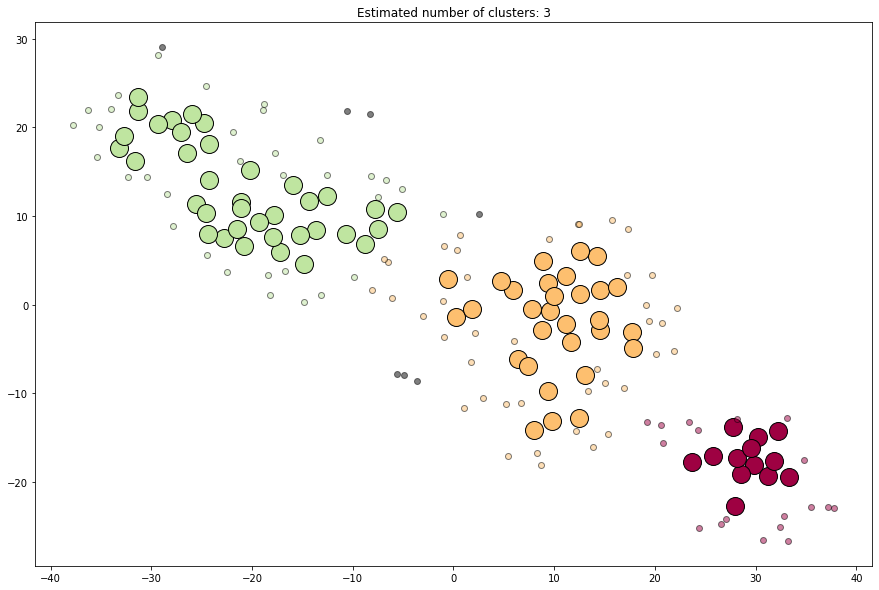

In [586]:
%matplotlib inline

# Black removed and is used for noise instead.
plt.figure(figsize=(15, 10))
unique_labels = set(db_labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (db_labels == k)

    xy = df[class_member_mask & core_samples_mask]
    plt.plot(xy.loc[:, 0], xy.loc[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=18)

    xy = df[class_member_mask & ~core_samples_mask]
    plt.plot(xy.loc[:, 0], xy.loc[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6, alpha=0.5)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Verifying result from clusters

In [587]:
def show_barchart(class_locations, mColor):
    df_ = pd.DataFrame(class_locations)
    df_.columns = ["Country", "Count"]
    df_ = df_.sort_values(by=['Count'])
    df_.plot.barh(x='Country', y='Count', color=mColor)

Labels distribution: {0: 31, 1: 71, 2: 70, -1: 7}


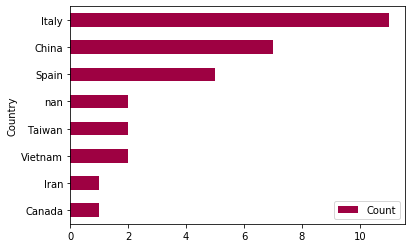

In [588]:
print(f"Labels distribution: {dict(Counter(db_labels))}")

class_0_locations = []
for idx, row in df_meta[df_meta['labels'] == 0].iterrows():
    location = str(row["location"]).split(",")[-1].strip()
    class_0_locations.append(location)

class_0_locations = sorted(dict(Counter(class_0_locations)).items(), key=lambda x: x[1], reverse=True)
show_barchart(class_0_locations, colors[0])

Labels distribution: {0: 31, 1: 71, 2: 70, -1: 7}


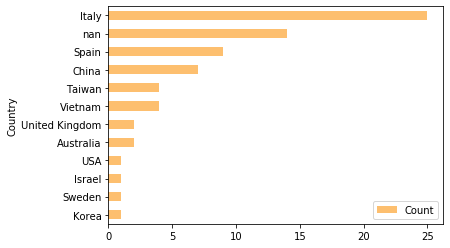

In [589]:
print(f"Labels distribution: {dict(Counter(db_labels))}")

class_1_locations = []
for idx, row in df_meta[df_meta['labels'] == 1].iterrows():
    location = str(row["location"]).split(",")[-1].strip()
    class_1_locations.append(location)

class_1_locations = sorted(dict(Counter(class_1_locations)).items(), key=lambda x: x[1], reverse=True)
show_barchart(class_1_locations, colors[1])

Labels distribution: {0: 31, 1: 71, 2: 70, -1: 7}


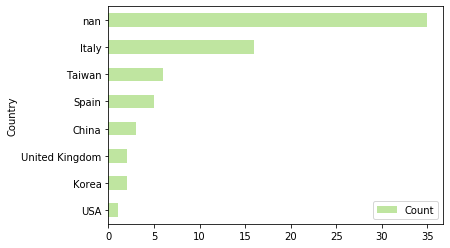

In [590]:
print(f"Labels distribution: {dict(Counter(db_labels))}")

class_2_locations = []
for idx, row in df_meta[df_meta['labels'] == 2].iterrows():
    location = str(row["location"]).split(",")[-1].strip()
    class_2_locations.append(location)

class_2_locations = sorted(dict(Counter(class_2_locations)).items(), key=lambda x: x[1], reverse=True)
show_barchart(class_2_locations, colors[2])

# Export to HTML

In [548]:
!jupyter nbconvert ClassifierV2.ipynb --to html

[NbConvertApp] Converting notebook ClassifierV2.ipynb to html
[NbConvertApp] Writing 1178191 bytes to ClassifierV2.html
